Loaded responses: 72 rows
Expanded to long: 216 model-rank rows
Models: ['microsam', 'unet_image_clip', 'unet_random']


,n,best,middle,worst,mean_rank,best_rate,worst_rate
model,,,,,,,
unet_image_clip,72,40,27,5,1.513889,0.555556,0.069444
unet_random,72,21,31,20,1.986111,0.291667,0.277778
microsam,72,11,14,47,2.500000,0.152778,0.652778


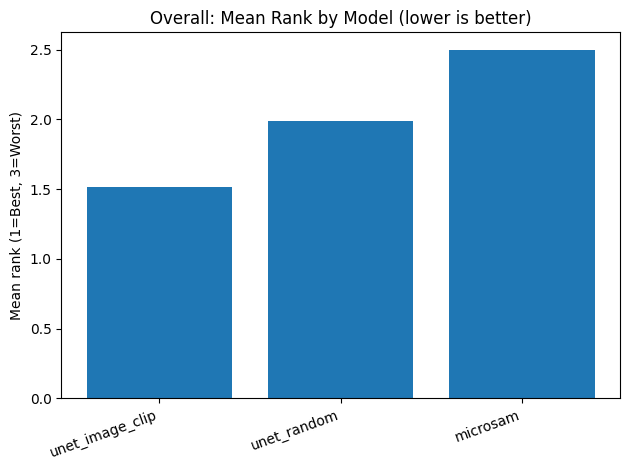

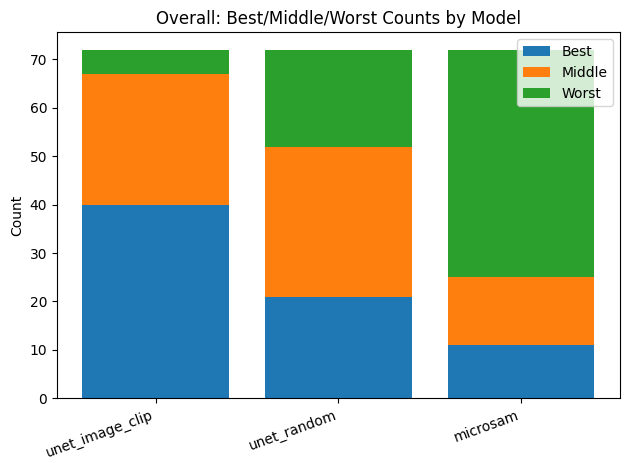

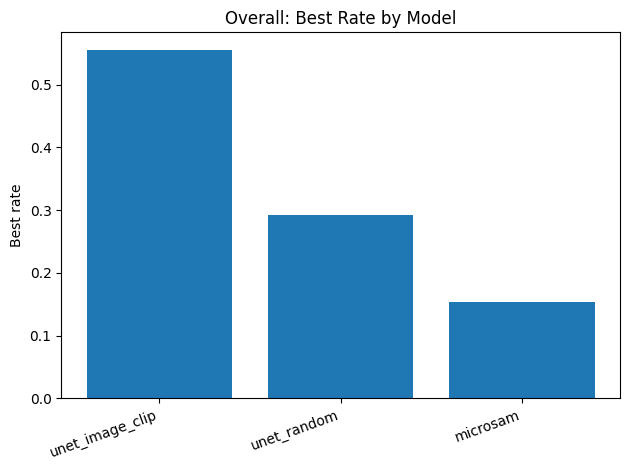


Mean rank by user (pivot):


model,microsam,unet_image_clip,unet_random
user_id,,,
Adi,2.5,1.513889,1.986111


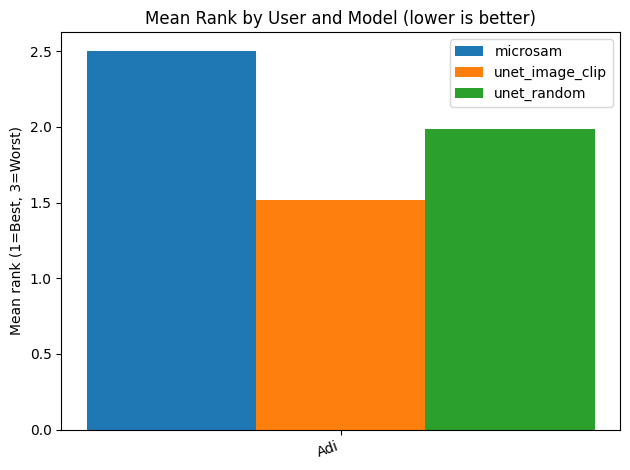

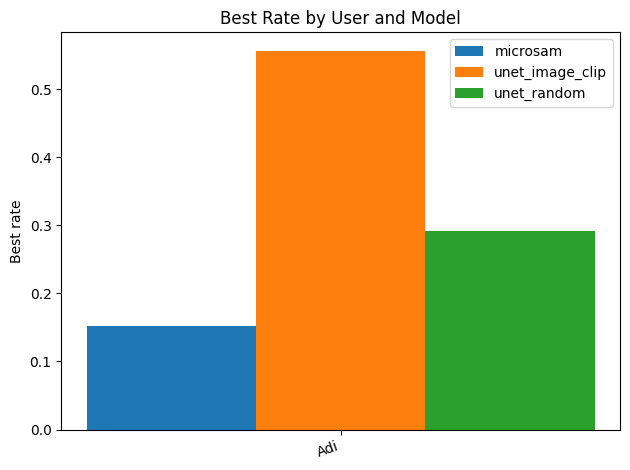


Mean rank by datatype (pivot):


model,microsam,unet_image_clip,unet_random
datatype,,,
amyloid_plaque,2.166667,1.458333,2.375000
cell_nucleus,3.000000,1.375000,1.625000
vessels,2.333333,1.708333,1.958333


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================
# 0) CONFIG: point this to your downloaded file
# ============================================
# Example:
# FILE = Path("/Users/you/Downloads/Responses - Responses.tsv")
# FILE = Path("/Users/you/Downloads/Responses - Responses.csv")
FILE = Path("/midtier/paetzollab/scratch/ads4015/ssl_streamlit/segmentation_eval_results - Responses.csv")  # <-- CHANGE ME

RANK_TO_SCORE = {"Best": 1, "Middle": 2, "Worst": 3}

NEEDED_COLS = [
    "response_id","timestamp","user_id","sample_id","datatype","z",
    "rankA","rankB","rankC","map_A","map_B","map_C"
]

# ============================================
# 1) LOAD (auto-detect tab vs comma)
# ============================================
if not FILE.exists():
    raise FileNotFoundError(f"File not found: {FILE}\nUpdate FILE to your downloaded Google Sheet export path.")

with open(FILE, "r", encoding="utf-8") as f:
    first_line = f.readline()

sep = "\t" if "\t" in first_line else ","
df = pd.read_csv(FILE, sep=sep, dtype=str, keep_default_na=False)
df.columns = [c.strip() for c in df.columns]

missing = [c for c in NEEDED_COLS if c not in df.columns]
if missing:
    raise ValueError(
        f"Missing columns: {missing}\n"
        f"Found columns: {list(df.columns)}\n"
        "Did you export the correct tab (Responses) and include header row?"
    )

# Normalize basic fields
df["user_id"] = df["user_id"].astype(str).str.strip()
df["datatype"] = df["datatype"].astype(str).str.strip()
df["sample_id"] = df["sample_id"].astype(str).str.strip()
df["z"] = pd.to_numeric(df["z"], errors="coerce")

# ============================================
# 2) RESHAPE to "long": one row per (response, model)
# ============================================
rows = []
for _, r in df.iterrows():
    for lab in ["A", "B", "C"]:
        model = str(r[f"map_{lab}"]).strip()
        rank  = str(r[f"rank{lab}"]).strip()
        if rank not in RANK_TO_SCORE:
            continue
        rows.append({
            "response_id": r["response_id"],
            "timestamp": r["timestamp"],
            "user_id": r["user_id"],
            "sample_id": r["sample_id"],
            "datatype": r["datatype"],
            "z": r["z"],
            "label": lab,              # A/B/C shown to rater
            "model": model,            # true method
            "rank_label": rank,        # Best/Middle/Worst
            "rank_score": RANK_TO_SCORE[rank],  # 1/2/3
        })

long = pd.DataFrame(rows)

# Convenience indicators
long["is_best"] = (long["rank_score"] == 1).astype(int)
long["is_middle"] = (long["rank_score"] == 2).astype(int)
long["is_worst"] = (long["rank_score"] == 3).astype(int)

print("Loaded responses:", len(df), "rows")
print("Expanded to long:", len(long), "model-rank rows")
print("Models:", sorted(long["model"].unique()))

# ============================================
# 3) OVERALL SUMMARY TABLE
# ============================================
overall = (long.groupby("model")
           .agg(
               n=("rank_score","size"),
               best=("is_best","sum"),
               middle=("is_middle","sum"),
               worst=("is_worst","sum"),
               mean_rank=("rank_score","mean"),
           )
           .sort_values(["mean_rank","best"], ascending=[True, False])
          )

overall["best_rate"] = overall["best"] / overall["n"]
overall["worst_rate"] = overall["worst"] / overall["n"]

display(overall)

models = list(overall.index)

# ============================================
# 4) PLOTS: OVERALL
# ============================================

# (A) Mean rank (lower is better)
plt.figure()
plt.bar(models, overall.loc[models, "mean_rank"].values)
plt.ylabel("Mean rank (1=Best, 3=Worst)")
plt.title("Overall: Mean Rank by Model (lower is better)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# (B) Best/Middle/Worst counts (stacked)
plt.figure()
best = overall.loc[models, "best"].values
mid  = overall.loc[models, "middle"].values
worst= overall.loc[models, "worst"].values
plt.bar(models, best, label="Best")
plt.bar(models, mid, bottom=best, label="Middle")
plt.bar(models, worst, bottom=best+mid, label="Worst")
plt.ylabel("Count")
plt.title("Overall: Best/Middle/Worst Counts by Model")
plt.xticks(rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# (C) Best rate
plt.figure()
plt.bar(models, overall.loc[models, "best_rate"].values)
plt.ylabel("Best rate")
plt.title("Overall: Best Rate by Model")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# ============================================
# 5) BY USER_ID
# ============================================
by_user = (long.groupby(["user_id","model"])
           .agg(
               n=("rank_score","size"),
               best=("is_best","sum"),
               middle=("is_middle","sum"),
               worst=("is_worst","sum"),
               mean_rank=("rank_score","mean"),
           )
           .reset_index()
          )
by_user["best_rate"] = by_user["best"] / by_user["n"]

print("\nMean rank by user (pivot):")
display(by_user.pivot(index="user_id", columns="model", values="mean_rank"))

users = list(by_user["user_id"].unique())
models_all = sorted(long["model"].unique())

x = np.arange(len(users))
width = 0.8 / max(1, len(models_all))

# (A) Mean rank by user
plt.figure()
for i, m in enumerate(models_all):
    vals = []
    for u in users:
        row = by_user[(by_user.user_id==u) & (by_user.model==m)]
        vals.append(row["mean_rank"].iloc[0] if len(row) else np.nan)
    plt.bar(x + i*width, vals, width, label=m)
plt.ylabel("Mean rank (1=Best, 3=Worst)")
plt.title("Mean Rank by User and Model (lower is better)")
plt.xticks(x + width*(len(models_all)-1)/2, users, rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# (B) Best-rate by user
plt.figure()
for i, m in enumerate(models_all):
    vals = []
    for u in users:
        row = by_user[(by_user.user_id==u) & (by_user.model==m)]
        vals.append(row["best_rate"].iloc[0] if len(row) else np.nan)
    plt.bar(x + i*width, vals, width, label=m)
plt.ylabel("Best rate")
plt.title("Best Rate by User and Model")
plt.xticks(x + width*(len(models_all)-1)/2, users, rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# 6) OPTIONAL: BY DATATYPE
# ============================================
by_dtype = (long.groupby(["datatype","model"])
            .agg(
                n=("rank_score","size"),
                best=("is_best","sum"),
                middle=("is_middle","sum"),
                worst=("is_worst","sum"),
                mean_rank=("rank_score","mean"),
            )
            .reset_index()
           )
by_dtype["best_rate"] = by_dtype["best"] / by_dtype["n"]

print("\nMean rank by datatype (pivot):")
display(by_dtype.pivot(index="datatype", columns="model", values="mean_rank"))
